### **Before you run this make sure you have the OPENAI_API_KEY and TAVILY_API_KEY environment variables declared**

### 1 Define the tool

Define the web search tool

In [1]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki',
   'url': 'https://deepwiki.com/langchain-ai/langgraph-101/2.2-nodes-and-edges',
   'content': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki Nodes and Edges Nodes and Edges What are Nodes and Edges? In LangGraph, a graph is composed of nodes connected by edges to form a directed workflow. Nodes are the workhorses of LangGraph - they are Python functions that receive the current graph state as input, perform operations, and return updates to that state. Edges define the flow of execution between nodes in a LangGraph. graph_builder.add_edge("retrieve_documents", "generate_response") Conditional edges use a function to determine the next node based on the current state. Building a Graph with Nodes and Edges graph_builder.add_node("retrieve_documents", retrieve_documents) graph_builder.add_edge(

The results are page summaries our chat bot can use to answer questions


### 2 Define the graph
For the `StateGraph` you created in the first tutorial, add `bind_tools` on the LLM. This lets the LLM know the correct JSON format to use if it wants to use the search engine.

Let's first select our LLM:

In [2]:
import os
from langchain.chat_models import init_chat_model
llm = init_chat_model("openai:gpt-4.1")

 We can now incorporate it into a `StateGraph`

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

### 3 Create a function to run the tools
Now, create a function to run the tools if they are called. Do this by adding the tools to a new node called `BasicToolNode` that checks the most recent message in the state and calls tools if the message contains `tool_calls`. It relies on the LLM's `tool_calling` support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

In [4]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

### 4 Define the `conditional_edges`
With the tool node added, now you can define the conditional_edges.

**Edges** route the control flow from one node to the next. **Conditional edges** start from a single node and usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph `state` and return a string or list of strings indicating which node(s) to call next.

Next, define a router function called `route_tools` that checks for `tool_calls` in the chatbot's output. Provide this function to the graph by calling `add_conditional_edges`, which tells the graph that whenever the `chatbot` node completes to check this function to see where to go next.

The condition will route to `tools` if tool calls are present and `END` if not. Because the condition can return `END`, you do not need to explicitly set a finish_point this time.

In [5]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

### 5 Visualize the graph
You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `draw_png`. The draw methods each require additional dependencies.

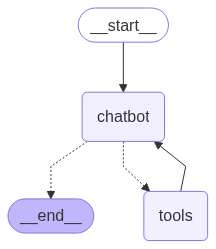

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 6 Ask the bot questions
Now you can ask the chatbot questions outside its training data:

In [7]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Goodbye!


### Add Memory
The chatbot can now use tools to answer user questions, but it does not remember the context of previous interactions. This limits its ability to have coherent, multi-turn conversations.

LangGraph solves this problem through **persistent checkpointing**. If you provide a `checkpointer` when compiling the graph and a `thread_id` when calling your graph, LangGraph automatically saves the state after each step. When you invoke the graph again using the same `thread_id`, the graph loads its saved state, allowing the chatbot to pick up where it left off.

We will see later that **checkpointing** is much more powerful than simple chat memory - it lets you save and resume complex state at any time for error recovery, human-in-the-loop workflows, time travel interactions, and more. But first, let's add checkpointing to enable multi-turn conversations.

### 1 Create a `MemorySaver` checkpointer
Create a `MemorySaver` checkpointer:

In [8]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

This is in-memory checkpointer, which is convenient for the tutorial. However, in a production application, you would likely change this to use `SqliteSaver` or `PostgresSaver` and connect a database.

### 2. Compile the graph
Compile the graph with the provided checkpointer, which will checkpoint the `State` as the graph works through each node:

In [9]:
graph = graph_builder.compile(checkpointer=memory)

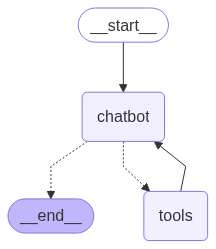

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 3 Interact with your chatbot

Now you can interact with your bot!

1. Pick a thread to use as the key for this conversation.

In [11]:
config = {"configurable": {"thread_id": "1"}}

2. Call your chatbot:

In [12]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hi Will! Nice to meet you. How can I help you today?


### 4 Ask a follow up question
Ask a follow up question:

In [13]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Will! If you want me to remember anything else or help you with something, just let me know.


**Notice** that we aren't using an external list for memory: it's all handled by the checkpointer! You can inspect the full execution in this LangSmith trace to see what's going on.

Don't believe me? Try this using a different config.

In [14]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

You haven’t told me your name yet. What’s your name?


**Notice** that the **only** change we've made is to modify the `thread_id` in the config.

### 5 Inpect the state
By now, we have made a few checkpoints across two different threads. But what goes into a checkpoint? To inspect a graph's `state` for a given config at any time, call `get_state(config)`.

In [15]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='ac75fc66-a882-4367-a381-20946254444a'), AIMessage(content='Hi Will! Nice to meet you. How can I help you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 775, 'total_tokens': 791, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_ccc6ec921d', 'id': 'chatcmpl-BZUNcMmqTkq43Zf1dbBXLGyTH3IVw', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8f1b926d-5d7f-4c22-a8fb-1198e35ba224-0', usage_metadata={'input_tokens': 775, 'output_tokens': 16, 'total_tokens': 791, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'aud

In [16]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

The snapshot above contains the current state values, corresponding config, and the `next` node to process. In our case, the graph has reached an `END` state, so `next` is empty.

**Congratulations**! Your chatbot can now maintain conversation state across sessions thanks to LangGraph's checkpointing system. This opens up exciting possibilities for more natural, contextual interactions. LangGraph's checkpointing even handles **arbitrarily complex graph states**, which is much more expressive and powerful than simple chat memory.

### Add human-in-the-loop controls
Agents can be unreliable and may need human input to successfully accomplish tasks. Similarly, for some actions, you may want to require human approval before running to ensure that everything is running as intended.

LangGraph's persistence layer supports **human-in-the-loop** workflows, allowing execution to pause and resume based on user feedback. The primary interface to this functionality is the `interrupt` function. Calling `interrupt` inside a node will pause execution. Execution can be resumed, together with new input from a human, by passing in a Command. `interrupt` is ergonomically similar to Python's built-in input(), with some caveats.

### 1 Add the `human_assistance` tool
Starting with the existing code from the Add memory to the chatbot tutorial, add the `human_assistance` tool to the chatbot. This tool uses `interrupt` to receive information from a human.

Let's first select a chat model:

In [17]:
llm = init_chat_model("openai:gpt-4.1")

We can now incorporate it into our `StateGraph` with an additional tool:

In [18]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

### 2 Compile the graph
We compile the graph with a checkpointer, as before:

In [19]:
memory = MemorySaver()

graph = graph_builder.compile(checkpointer=memory)

### 3. Visualize the graph
Visualizing the graph, you get the same layout as before – just with the added tool!

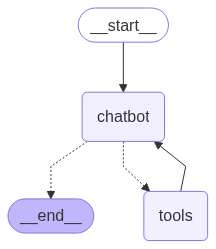

In [20]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 4 Prompt the chatbot
Now, prompt the chatbot with a question that will engage the new `human_assistance` tool:

In [21]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_owE9jSWRnTkTFaB0MuwpiDRm)
 Call ID: call_owE9jSWRnTkTFaB0MuwpiDRm
  Args:
    query: The user needs expert guidance for building an AI agent. Can you assist or provide advice on best practices, resources, or consultation options?


The chatbot generated a tool call, but then execution has been interrupted. If you inspect the graph state, you see that it stopped at the tools node:

In [22]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

### 5 Resume execution
To resume execution, pass a `Command` object containing data expected by the tool. The format of this data can be customized based on needs. For this example, use a dict with a key `"data"`:

In [23]:
human_response = (
    "We, the experts are here to help! We'd recommend you check out LangGraph to build your agent."
    " It's much more reliable and extensible than simple autonomous agents."
)

human_command = Command(resume={"data": human_response})

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_owE9jSWRnTkTFaB0MuwpiDRm)
 Call ID: call_owE9jSWRnTkTFaB0MuwpiDRm
  Args:
    query: The user needs expert guidance for building an AI agent. Can you assist or provide advice on best practices, resources, or consultation options?
================================= Tool Message =================================
Name: human_assistance

We, the experts are here to help! We'd recommend you check out LangGraph to build your agent. It's much more reliable and extensible than simple autonomous agents.
================================== Ai Message ==================================

An expert recommends checking out LangGraph for building your AI agent. LangGraph is considered more reliable and extensible than traditional autonomous agents, making it a strong starting point for robust agent design.

If you’d like, I can provide more details about LangGraph or resources to help y

The input has been received and processed as a tool message. Notice that the state is loaded in the first step so that our chatbot can continue where it left off.

**Congratulations!** You've used an interrupt to add human-in-the-loop execution to your chatbot, allowing for human oversight and intervention when needed. This opens up the potential UIs you can create with your AI systems. Since you have already added a **checkpointer**, as long as the underlying persistence layer is running, the graph can be paused **indefinitely** and resumed at any time as if nothing had happened.